In [1]:
# In Terminal, "pip install ibis-framework[duckdb] pyjanitor"
import pandas as pd
import ibis
from ibis import selectors as s
from ibis import _
ibis.options.interactive = True

In [2]:
import seaborn as sns

### Input data

In [3]:
df1 = pd.read_csv("STI sample.csv")

In [4]:
t1 = ibis.memtable(df1)
t1.head(3)

┏━━━━━━━┳━━━━━━━━━━┓
┃ no.   ┃ salary   ┃
┡━━━━━━━╇━━━━━━━━━━┩
│ int64 │ int64    │
├───────┼──────────┤
│     1 │ 58152000 │
│     2 │ 65448000 │
│     3 │ 55728000 │
└───────┴──────────┘

In [5]:
vt_group = pd.Series(range(201))
df2 = pd.DataFrame({"vt_group": vt_group})

In [6]:
t2 = ibis.memtable(df2)
t2.head(3)

┏━━━━━━━━━━┓
┃ vt_group ┃
┡━━━━━━━━━━┩
│ int64    │
├──────────┤
│        0 │
│        1 │
│        2 │
└──────────┘

In [13]:
incentive_target = [5, 10, 15]
df3 = pd.DataFrame({'incentive_target': incentive_target})

In [14]:
t3 = ibis.memtable(df3)
t3.head()

┏━━━━━━━━━━━━━━━━━━┓
┃ incentive_target ┃
┡━━━━━━━━━━━━━━━━━━┩
│ int64            │
├──────────────────┤
│                5 │
│               10 │
│               15 │
└──────────────────┘

In [ ]:
personal_contribution = ["Outstanding", "Exceptional", "Accomplished", "Below Ambition"]

### Test for an individual case: group performance 153% and incentive target 10%

In [93]:
# personal_contribution_pick = "Accomplished"
def personal(vt_group_value):
    if vt_group_value < 50:
        return 80
    elif vt_group_value < 85:
        return 100
    elif vt_group_value < 140:
        return 120
    else:
        return 160

In [94]:
def financial_calc(vt_group_value):
    a = vt_group_value * 0.5
    b = personal(vt_group_value) * 0.5
    return a + b

In [95]:
# vt_group = 153 or 50
temp = (t1
    .mutate(
        a = (153) * 0.5,
        b = personal(153) * 0.5,
        financial_achievement = financial_calc(153),
        incentive_target = 10,
    )
    .mutate(incentive = (_.salary * _.financial_achievement * _.incentive_target / 10**4).round(0))
 )
temp.head(3)

┏━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ no.   ┃ salary   ┃ a       ┃ b       ┃ financial_achievement ┃ incentive_target ┃ incentive    ┃
┡━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ int64 │ int64    │ float64 │ float64 │ float64               │ int8             │ float64      │
├───────┼──────────┼─────────┼─────────┼───────────────────────┼──────────────────┼──────────────┤
│     1 │ 58152000 │    76.5 │    80.0 │                 156.5 │               10 │ 9.100788e+06 │
│     2 │ 65448000 │    76.5 │    80.0 │                 156.5 │               10 │ 1.024261e+07 │
│     3 │ 55728000 │    76.5 │    80.0 │                 156.5 │               10 │ 8.721432e+06 │
└───────┴──────────┴─────────┴─────────┴───────────────────────┴──────────────────┴──────────────┘

In [96]:
temp.aggregate(average = _.incentive.mean(), total = _.incentive.sum())

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ average      ┃ total        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ float64      │ float64      │
├──────────────┼──────────────┤
│ 9.658615e+06 │ 2.095919e+09 │
└──────────────┴──────────────┘

### Cross Join for various vt_group, with incentive target 10%

In [15]:
t = (t3
    .join(t2, how="cross")
    .join(t1, how="cross")
)
t.head(3)

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┓
┃ incentive_target ┃ vt_group ┃ no.   ┃ salary   ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━┩
│ int64            │ int64    │ int64 │ int64    │
├──────────────────┼──────────┼───────┼──────────┤
│                5 │        0 │     1 │ 58152000 │
│                5 │        0 │     2 │ 65448000 │
│                5 │        0 │     3 │ 55728000 │
└──────────────────┴──────────┴───────┴──────────┘

In [16]:
t = (t
    .mutate(
        a = _.vt_group * 0.5,
        b = ibis.case()
            .when(t.vt_group < 50, 80)
            .when(t.vt_group < 85, 100)
            .when(t.vt_group < 140, 120)
            .when(True, 160)
            .end() * 0.5,
    )
    .mutate(
        financial_achievement = _.a + _.b,
        # incentive_target = 10,
    )
    .mutate(incentive = (_.salary * _.financial_achievement * _.incentive_target / 10**4).round(0))
 )
t.head(3)

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ incentive_target ┃ vt_group ┃ no.   ┃ salary   ┃ a       ┃ b       ┃ financial_achievement ┃ incentive    ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ int64            │ int64    │ int64 │ int64    │ float64 │ float64 │ float64               │ float64      │
├──────────────────┼──────────┼───────┼──────────┼─────────┼─────────┼───────────────────────┼──────────────┤
│                5 │        0 │     1 │ 58152000 │     0.0 │    40.0 │                  40.0 │ 1.163040e+06 │
│                5 │        0 │     2 │ 65448000 │     0.0 │    40.0 │                  40.0 │ 1.308960e+06 │
│                5 │        0 │     3 │ 55728000 │     0.0 │    40.0 │                  40.0 │ 1.114560e+06 │
└──────────────────┴──────────┴───────┴──────────┴─────────┴─────────┴───────────────────────┴──────────────┘

In [17]:
interim = t.to_pandas()
interim.to_csv("temp.csv", index=False)
interim

,incentive_target,vt_group,no.,salary,a,b,financial_achievement,incentive
0,5,0,1,58152000,0.0,40.0,40.0,1163040.0
1,5,0,2,65448000,0.0,40.0,40.0,1308960.0
2,5,0,3,55728000,0.0,40.0,40.0,1114560.0
3,5,0,4,57336000,0.0,40.0,40.0,1146720.0
4,5,0,5,62736000,0.0,40.0,40.0,1254720.0
...,...,...,...,...,...,...,...,...
130846,15,200,213,57576000,100.0,80.0,180.0,15545520.0
130847,15,200,214,57384000,100.0,80.0,180.0,15493680.0
130848,15,200,215,65760000,100.0,80.0,180.0,17755200.0
130849,15,200,216,75264000,100.0,80.0,180.0,20321280.0


In [19]:
result = t.group_by(["incentive_target", "vt_group", "a", "b", "financial_achievement"]).aggregate(
    average_salary = _.salary.mean(),
    total_salary = _.salary.sum(),
    average_incentive = _.incentive.mean(),
    total_incentive = _.incentive.sum(),
    )
result.head(3)


┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ incentive_target ┃ vt_group ┃ a       ┃ b       ┃ financial_achievement ┃ average_salary ┃ total_salary ┃ average_incentive ┃ total_incentive ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ int64            │ int64    │ float64 │ float64 │ float64               │ float64        │ int64        │ float64           │ float64         │
├──────────────────┼──────────┼─────────┼─────────┼───────────────────────┼────────────────┼──────────────┼───────────────────┼─────────────────┤
│                5 │        0 │     0.0 │    40.0 │                  40.0 │   6.171639e+07 │  13392456000 │      1.234328e+06 │    2.678491e+08 │
│                5 │        1 │     0.5 │    40.0 │                  40.5 │   6.171639e+07 │  13392456000 │      1.249757e+06 │    2.711972e+08 │
│                5 │        2 │     1.0 │    40.0 │                  41.0 │   6.171639e+07 │  13392456000 │      1.265186e+06 │    2.745453e+08 │
└──────────────────┴──────────┴─────────┴─────────┴───────────────────────┴────────────────┴──────────────┴───────────────────┴─────────────────┘

In [20]:
# Output data
df_result = result.to_pandas()
df_result.to_csv("result.csv", index=False)
df_result


,incentive_target,vt_group,a,b,financial_achievement,average_salary,total_salary,average_incentive,total_incentive
0,5,0,0.0,40.0,40.0,6.171639e+07,13392456000,1.234328e+06,2.678491e+08
1,5,1,0.5,40.0,40.5,6.171639e+07,13392456000,1.249757e+06,2.711972e+08
2,5,2,1.0,40.0,41.0,6.171639e+07,13392456000,1.265186e+06,2.745453e+08
3,5,3,1.5,40.0,41.5,6.171639e+07,13392456000,1.280615e+06,2.778935e+08
4,5,4,2.0,40.0,42.0,6.171639e+07,13392456000,1.296044e+06,2.812416e+08
...,...,...,...,...,...,...,...,...,...
598,10,149,74.5,80.0,154.5,6.171639e+07,13392456000,9.535182e+06,2.069134e+09
599,15,59,29.5,50.0,79.5,6.171639e+07,13392456000,7.359679e+06,1.597050e+09
600,15,70,35.0,50.0,85.0,6.171639e+07,13392456000,7.868839e+06,1.707538e+09
601,15,112,56.0,60.0,116.0,6.171639e+07,13392456000,1.073865e+07,2.330287e+09


### Visualization

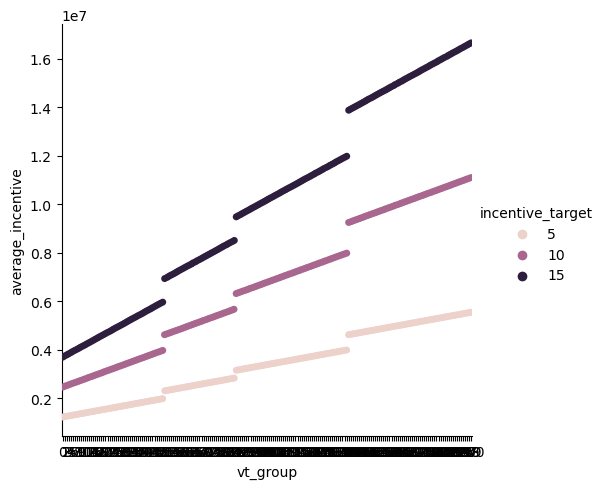

In [21]:
# Average incentive
sns.catplot(data=df_result, hue="incentive_target",
            x="vt_group", y="average_incentive");

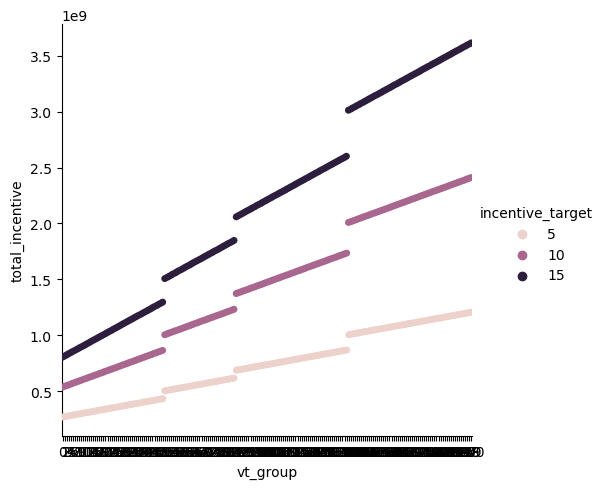

In [22]:
# Total incentive
sns.catplot(data=df_result, hue="incentive_target",
            x="vt_group", y="total_incentive");

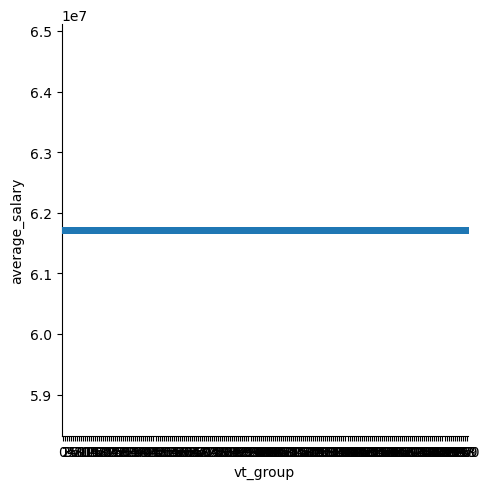

In [26]:
# Average salary
sns.catplot(data=df_result,
            x="vt_group", y="average_salary");

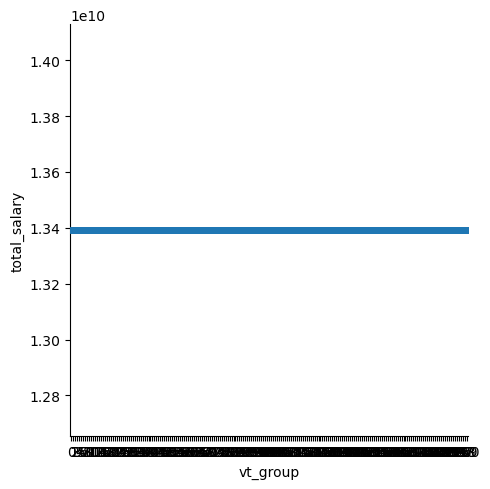

In [27]:
# Total salary
sns.catplot(data=df_result,
            x="vt_group", y="total_salary");